### Breaking a captcha using multi-class classification with Tensorflow and convolutional neural networks

# Background

A few years ago I had the idea of attempting an experiment that would follow the process of how easy (or difficult) it would be to create an online meme that at some point would spill over into real life. For this to work my intetion was to post a number of different comments after each article of a popular news site. I realise the ethical implications of this and my intetion was to not spam and break the commenting functionality for other users, rather than post one comment after each article. I figured it would take a year or two before this catches on. This was also something I wanted to explore, the time it would take for this to become reality. The message itself would be an in itself with no obvious meaning.

I was really enthusiastic about this project until I stumbled into what was to become a huge blocker for me. The comment section was protected by a captcha. Initially the captcha looked surprisingly simple and I thought using readily available OCR libraries would suffice. Let's inspect an example of it:

**Insert image**


In [1]:
# We'll need to import the Image API from the Pillow library (PIL), 
# which is really useful for image manipulation

from PIL import Image

# Open the image 

img = Image.open('code.jpeg')

# Check the basic information for the image

img.size, img.format, img.mode

((168, 30), 'JPEG', 'RGB')

We can see here that the image is 168 pixels wide and 30 pixels high. The format is JPEG and the colour mode is RGB. This doesn't seem very useful for now but we'll use all of this information to devise a strategy for breaking the captcha.

## Retrospective of the investigation 

As I previously mentioned, the first thing that came to my mind was OCR using a powerful OCR engine called [Tesseract](https://github.com/tesseract-ocr/tesseract). It did not produce meaningful results, so I decided to enhance the image and make it easier for Tesseract to read it.

Since the digits in the image are dotted by clusters of pixels with lighter colours, I decided to use PIL and fill the lighter pixels surrounded by darker ones with colour and then convert the image to grayscale. Needless to say that didn't work. 



## Enter machine learning

After failing to use OCR on the image, I figured I would give machine learning a try. Initially I looked up already available guides and code for this specific problem. I was trying to quickly sort it out and proceed with the rest of the code as I had no interest to dig deeper into machine learning. None of the materials I came across were able to do the job for me or rather I wasn't able to figure out how to adapt them to my data.

Eventually I gave up and set this aside for a couple of years. Meanwhile I developed an interest in machine learning and decided to take a systematic approach and start getting familiar with the Tensorflow framework from scratch. 

Normally solving this captcha (or any really) would be a use case for **object detection**. As opposed to the **classification** problems, where you need to assign a label to an image, in most captchas you need to label multiple objects inside an image.

After inspecting the example captcha a bit closer, I figured I can easily turn it into a classification dataset. It seems that if you split the image in 5 equal parts, you would get smaller images with one digit in them. This would allow for a smaller input size and thus faster training of the machine learning model. It's also much simpler and quicker to create the model from scratch.

## Creating the datasets

I created a helper script to split all images in 5 equal parts. Afterwards I created the following directory structure for my train and test datasets:

```
single_digits
└───train
│   └───0
│   └───1
│   └───2
│   └───3
│   └───4
│   └───5
│   ....
└───test
```

We have a `train` directory, which has sub-directories named after each label (0 to 9). The `test` directory is identical to `train` with the same sub-directories.

I then started manually moving each image to it's corresponding directory. Grouping the images under the sub-directories is a process called data labeling. 

For this tutorial I'll be using Google Colab, since we have the option of using a GPU free of charge. I'll be uploading the archived directory which contains the datasets directly in Colab.

In [2]:
import zipfile


# Unzip the uploaded file

zip_ref = zipfile.ZipFile("single_digits.zip")
zip_ref.extractall()
zip_ref.close()


Let's load and inspect our data:

In [4]:
# We define the path to our train and test datasets for convenience
train_dir = 'single_digits/train'
test_dir = 'single_digits/test'

A good way to make sure we have all of our classes right, we can traverse the sub-directories and store the directory names as class names.

In [5]:
# Get the class names

import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # Create a list of class names from the sub directories
class_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')


## Data representation of an image

It's worth to step back and look into how an image is represtented as data. I won't go into too much detail and will give outlines of what we'll need for this task. A grayscale image has just one colour channel, while an RGB (Red, Green, Blue) has three channels. What this means is:

>each channel has 8 bits, for red, green, and blue—in other words, the image is composed of three images (one for each channel), where each image can store discrete pixels with conventional brightness intensities between 0 and 255.

[Channel (digital image)](https://en.wikipedia.org/wiki/Channel_(digital_image)


Now let's inspect one of our images:

In [6]:
# We'll use matplotlib to get the numerical value of an image

import matplotlib.image as mpimg

img = mpimg.imread('code.jpeg')

img

array([[[255, 253, 255],
        [240, 235, 239],
        [255, 252, 255],
        ...,
        [163, 150, 160],
        [148, 136, 148],
        [255, 248, 255]],

       [[255, 253, 255],
        [255, 253, 255],
        [253, 246, 253],
        ...,
        [255, 251, 251],
        [255, 252, 253],
        [255, 248, 251]],

       [[244, 239, 243],
        [255, 253, 255],
        [161, 154, 161],
        ...,
        [255, 252, 250],
        [236, 228, 226],
        [255, 254, 251]],

       ...,

       [[251, 255, 250],
        [254, 255, 251],
        [255, 252, 251],
        ...,
        [167, 141, 150],
        [255, 246, 255],
        [255, 249, 255]],

       [[251, 255, 250],
        [245, 248, 241],
        [252, 248, 247],
        ...,
        [255, 249, 255],
        [255, 247, 251],
        [255, 244, 248]],

       [[239, 246, 238],
        [254, 255, 250],
        [255, 254, 253],
        ...,
        [252, 241, 245],
        [255, 255, 255],
        [252, 252, 252]]

The image is represented by an array with numbers between 0 and 255. These numbers signify the brightness intensity of each pixel in the image.

Having all of this in mind, we can move on to solving the captcha.

## Preprocessing the data

Our data is not yet ready to feed into a Tensorflow model since it's not converted into tensors. For this reason we'll use the `ImageDataGenerator` which will bundle our data into batches and convert it into tensor image data.

Another important step here is rescaling our image data. The RGB channel data is between 0 and 255, while Tensorflow works optimally with smaller values. We can divide the data by 255, which will make all values in the range between 0 and 1.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling the images so their values are in the range between 0 and 1
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)



If you're wondering how will Tensorflow associate the image data with the labels, it does this for us by getting the names of the sub-directories and using them as labels.

We'll use the `flow_from_directory` method of the `ImageDataGenerator` to generate batches of images. The first argument is the directory path, followed by `target_size`, which resizes the images to a desired size. `batch_size` and `class_mode` use their default values, but I've added them for clarity. We can define the number of images in a batch and `class_mode` determines the type of label arrays that will be used. In our case `categorical` refers to 2D one-hot encoded labels. One hot encoding is an important concept in machine learning and if you're wondering [why one-hot encode data](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), this article explains it quite well.

In [8]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(30,32),
                                               batch_size=32,
                                               class_mode='categorical')
                                               
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(30,32),
                                              batch_size=32,
                                              class_mode='categorical')

Found 398 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


Now that we've created our batches, let's see what the images and labels look like:

In [9]:
# Inspect the first image of the first batch of our training data
images, labels = train_data.next()

images[0]

array([[[0.9843138 , 1.        , 0.95294124],
        [0.9294118 , 0.9568628 , 0.8941177 ],
        [0.6509804 , 0.6784314 , 0.6156863 ],
        ...,
        [0.57254905, 0.6039216 , 0.6117647 ],
        [0.9450981 , 0.9843138 , 0.98823535],
        [1.        , 0.9568628 , 1.        ]],

       [[0.9686275 , 1.        , 0.94117653],
        [0.77647066, 0.8078432 , 0.7490196 ],
        [0.96470594, 0.98823535, 0.9333334 ],
        ...,
        [0.9725491 , 1.        , 1.        ],
        [0.4901961 , 0.5294118 , 0.5254902 ],
        [0.98823535, 0.9490197 , 0.9921569 ]],

       [[0.9843138 , 1.        , 0.9803922 ],
        [0.9803922 , 1.        , 0.97647065],
        [0.91372555, 0.9333334 , 0.9058824 ],
        ...,
        [0.8862746 , 0.9294118 , 0.91372555],
        [0.9568628 , 1.        , 0.98823535],
        [1.        , 0.9843138 , 0.9921569 ]],

       ...,

       [[0.9960785 , 0.9960785 , 1.        ],
        [0.9960785 , 0.9960785 , 1.        ],
        [0.90196085, 0

The values in the images have been changed by `ImageDataGenerator` and they are now in the range between 0 and 1.

In [10]:
# Let's examine how the label of the first image will look like
labels[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

The labels have been one hot encoded and we have an array with 10 elements for each label. The indexes indicate the class names, so whenever we have 1 at a given index, this means this index indicate the correct class name.

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Sequential


## A few words on the architecture of a convolutional neural network

In the previous code box we've imported some of the key elements we'll use to create our machine learning model. We'll recreate the Tiny VGG architecture shown on the [CNN explainer](https://poloclub.github.io/cnn-explainer/) website. I won't go into too much details on convolutional neural networks, just share my broad understanding of them. This kind of thing mainly helps me process these concepts so bear with me.

A neural network is an algorithm which finds patterns in data. It takes tensors as input, processes them through layers each holding a number of neurons. Each neuron takes multiple inputs and produces one output.The function that is applied to the input values is determined by a vector of weights and a bias. The vector of weights and the bias are called filters and represent particular patterns in the input data. 

CNNs include convolutional layers, which are well suited to handle image data. For a convolutional layer we need to define a number of filters (also called kernels) and the size of the kernel. There are other hyperparameters that can be set, but we'll use their default for this example. You can think of the kernel as a user defined square of pixels that goes systematically goes through our image data. This is very well illustrated in the CNN explainer website.

The model is created by sequentially going through the layers as defined in the code box below, hence why the Tensorflow class is named `Sequential`. The first layer is our **input layer**, here we define the number of output filters in the convolution. The second parameters is the kernel size (3), the kernel will be 3x3. We then set the activation function, in our case this is ReLU, which is a non-linear function. To put it simply it can draw a curved (not straight) line through given dots in a coordinate system. We need this because especially for images it's not effective to use straight lines to identify patterns. Lastly we define the input shape of our data. We are using a dataset with images that are 30 pixels high and 32 in width with 3 colour channels.

We define a second layer almost identical to the first one without the input shape, as the input of the second layer will be the output of the first one, rather than our dataset. Afterwards we have an interesting one which is called a **pooling layer**.

What this max pooling layer does is it slides another kernel through the output of the previous layers and takes the maximum number from within this kernel. It reduces the parameters and improves the performance of the neural network. We are using the default pool size of (2,2). 

The **flatten layer** converts the three-dimensional output of the previous layers into a one-dimensional input for the last layer. It uses the softmax activation function, which requires an input of this shape. The last layer is defined with 10 units because we have 10 different classes for each digit from 0 to 9. This is the dimensiality of the output space. We usually set softmax as activation for multi-class classification.

In [12]:
model = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(30,32,3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

Afterwards we compile the model settings the loss, optimizer and metrics. I won't go into detail, it's only worth mentioning that these are pretty standard when it comes to multi-class classification.

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Finally we fit our model using the training data that we prepared earlier. For validation we use the test data i.e data it hasn't seen in the training phase. Since I used this as a baseline model I set it to train for 50 epochs initially, although this might not be optimal. The dataset is fairly small and it shouldn't take too much time.

In [14]:

history = model.fit(train_data,
                    epochs=50,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/50
13/13 [==============================] - 9s 54ms/step - loss: 2.3064 - accuracy: 0.0930 - val_loss: 2.2963 - val_accuracy: 0.0800
Epoch 2/50
13/13 [==============================] - 0s 22ms/step - loss: 2.2785 - accuracy: 0.1583 - val_loss: 2.2939 - val_accuracy: 0.1400
Epoch 3/50
13/13 [==============================] - 0s 23ms/step - loss: 2.2560 - accuracy: 0.1960 - val_loss: 2.2949 - val_accuracy: 0.1600
Epoch 4/50
13/13 [==============================] - 0s 23ms/step - loss: 2.2338 - accuracy: 0.2035 - val_loss: 2.2906 - val_accuracy: 0.1600
Epoch 5/50
13/13 [==============================] - 0s 24ms/step - loss: 2.1938 - accuracy: 0.2312 - val_loss: 2.2608 - val_accuracy: 0.1700
Epoch 6/50
13/13 [==============================] - 0s 22ms/step - loss: 2.1346 - accuracy: 0.2764 - val_loss: 2.2481 - val_accuracy: 0.2000
Epoch 7/50
13/13 [==============================] - 0s 23ms/step - loss: 2.0437 - accuracy: 0.3090 - val_loss: 2.0857 - val_accuracy: 0.3000
Epoch 8/50
13

Even with implementing a very standard Tiny VGG architecture, we're getting good results. Training accuracy is almost 99% and validation accuracy is 93%. We can tune various parameters here and there and probably get even better results, but this should be more than enough for accurate predictions.

Still it's useful to know how our model's training and validation progressed. The best way is to visualize the output of the training. Below I'm using a function that I copied from Dan Bourke's awesome [machine learning course](https://github.com/mrdbourke/tensorflow-deep-learning) which helped me a lot.

There are better ways to visualize these curves like using Tensorboard, but let's keep it simple for now. You can also plot them directly from the history object and not separate them, but I find it more difficult to quickly make sense of the loss curves.

In [21]:
import matplotlib.pyplot as plt
# Plot the validation and training curves separately

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss'])) # how many epochs

  # Plot loss
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Training accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

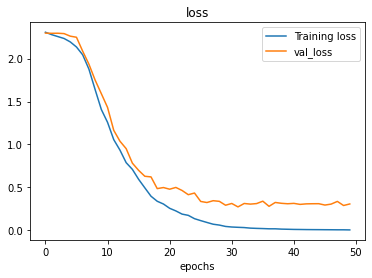

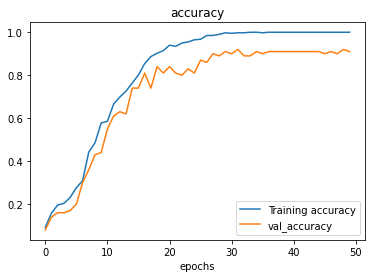

In [16]:
plot_loss_curves(history)

We can see that somewhere between epoch 30 and 40 the loss stops decreasing, so it should probably be fine if we decrease the number of epochs. It's accurate enough as it is, we'll leave it that way. 

A helper function that will be needed is `crop`, which as the name suggests will crop the input image into 5 separate ones. Doing this will allow us to use the trained model on each individual digit from the code image.

In [17]:
def crop(filename, num_boxes=5):
  img = Image.open(filename)
  imgwidth, imgheight = img.size
  box_width = imgwidth / num_boxes

  left = 0
  upper = 0
  right = box_width
  lower = imgheight
  for i in range(0, num_boxes):
    cropped = img.crop((left + (i * box_width), upper, right + (i * box_width), lower))
    yield cropped

Another function will convert an image to a format suitable for the model to process. Tensorflow has some built in functionality that will read the image, convert it into a tensor, resize it into a given shape. 


In [19]:
import tensorflow as tf

def load_and_prep_image(filename, shape=(30,32)):
  """
  Reads an image from filename and turns it into a tensor and reshapes 
  it to the defined shape
  """
  # Read in image
  img = tf.io.read_file(filename)
  # Decode read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=shape)
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

Now let's put everything together into a function that receives the model, filename and class names and does a prediction.

In [22]:
import os

  
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model and plots
  the image with the predicted class as the title
  """
  all_preds = list()
  for cropped in crop(filename):
    # save the cropped image temporarily
    cropped.save('tmp.jpg')

    # Import the target image and preprocess it
    img = load_and_prep_image('tmp.jpg')
  
    # Make a prediction, we expand the dims as we get a 3 dimensional tensor, 
    # while the model expects a 4 dimensional one
    pred = model.predict(tf.expand_dims(img, axis=0))
    # we get the most likely class name by getting 
    # the maximum value for the predictions
    pred_class = class_names[tf.argmax(pred[0])]
    all_preds.append(pred_class)

  os.remove('tmp.jpg')
  complete_img = Image.open(filename, 'r')
  plt.imshow(np.asarray(complete_img))
  plt.title("Prediction: {}".format(''.join(all_preds)))
  plt.axis(False)


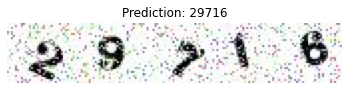

In [23]:
pred_and_plot(model, 'code.jpeg')

There we have it, our model is able to read an image correctly.

## Conclusion

I created this tutorial mainly for my personal development, I find you understand things better when you put them in text or explain them to someone. Besides it felt really nice when the model actually worked from the first time, it reminded me of my early school years when I was hacking stuff randomly on my computer and something ended up working incidentally. I tried to explain things as I understand them, it might not be as accurate or coherent as I'd imagine it is. Happy hacking!